# PROJ-H419 : Melanoma Classification


## 1. Introduction
This notebook presents a first approach to tackle the ISIC 2020 Challenge on melanoma classification. The challenge can be found on kaggle (https://www.kaggle.com/c/siim-isic-melanoma-classification) and all the datasets can be found there too. Furthermore, this notebook is widely inspired by gaggle courses on computer vision (https://www.kaggle.com/learn/computer-vision) and tensorflow tutorials (https://www.tensorflow.org/tutorials). 

The dataset provides tfrecord, DICOM, JPG and CSV files which contain different information about the patient. In this notebook, only the JPGs were used and were labelled with the help of the CSV files. Also, only the information about the malignancy of the melanoma is used to label the JPGs.

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


import pathlib
import pandas as pd

import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.metrics import plot_confusion_matrix  

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2.6.0


In [2]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## 2. Loading data

In [3]:
directory = '/Users/renau/Desktop/DATA/data_proj_melanoma'
#directory = '/Users/renau/Desktop/PROJ-H419/data'

train_df = pd.read_csv(directory + '/train.csv')

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names

path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'

train_df['path_jpeg'] = path_train

In [4]:
malignant_df = train_df[train_df['target'] == 1]
malignant_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [5]:
benin_df = train_df[train_df['target'] == 0]
benin_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


### 2.1 Unbalanced dataset

This code highlights the fact that the dataset is unbalanced. The malignant files represent less than two percents of the total files. This is a problem that has to be handled otherwise this could lead to not or less detect malignant melanomas.

In [6]:
mal_file = malignant_df['path_jpeg'].values
mal_labels = malignant_df['target'].values
mal_train_ds = tf.data.Dataset.from_tensor_slices((mal_file, mal_labels))
len(list(mal_train_ds))

584

In [7]:
ben_file = benin_df['path_jpeg'].values
ben_labels = benin_df['target'].values
ben_train_ds = tf.data.Dataset.from_tensor_slices((ben_file, ben_labels))
ben_train_ds = ben_train_ds.shuffle(len(list(ben_train_ds)))
len(list(ben_train_ds))

32542

### 2.2 Making a balanced dataset
There are different options in order to make a balanced dataset. For instance, the class in default can be oversampled or the class in excess can be under sampled. In a first time under sampling was chosen and a random sample of the class in excess is taken shuffled with all the element of the class in default. Finally, the data are split into data for the training and the validation.

In [8]:
def make_balanced_dataset(ds_class1, ds_class2):
    half_size = min(len(list(ds_class1)),len(list(ds_class2)))
    ds_1 = ds_class1.take(half_size)
    ds_2 = ds_class2.take(half_size)
    ds_full = ds_1.concatenate(ds_2)
    ds_full = ds_full.shuffle(half_size*2, reshuffle_each_iteration=False)
    return ds_full.skip((half_size*2)//5),ds_full.take((half_size*2)//5),

ds_train, ds_val = make_balanced_dataset(ben_train_ds,mal_train_ds)
size = len(list(ds_val))
print('Validation dataset size is',size, 'and training dataset size is' , len(list(ds_train)))

Validation dataset size is 233 and training dataset size is 935


In [9]:
ex_ds = ds_train.take(4)
for element in ex_ds :
    print(element[0].numpy(),'and target: ',element[1].numpy())

b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_6257422.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0599605.jpg' and target:  1
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0272026.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_2937642.jpg' and target:  1


### 2.3 Data preprocessing
In this, the data are labelled, gathered in mini-batch and resized. Images of different size can't be used to feed the model for mathematical reasons for instance normalization of the data and for coding reasons the inputs shape of model (size of the picture) has to be specified. 

In [10]:
def read_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype = tf.uint8, expand_animations = False)
    return image, label

ds_train = ds_train.map(read_image)
ds_val = ds_val.map(read_image)

In [11]:
ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].numpy().shape)

(480, 640, 3)
(2448, 3264, 3)
(4000, 6000, 3)


In [12]:
def adapt_data(image, label):
    image = tf.image.resize(image, [160,160])
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float64)
    return image, label
    
ds_train= ds_train.map(adapt_data).map(convert_to_float).batch(16)
ds_val= ds_val.map(adapt_data).map(convert_to_float).batch(16)

ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].shape)
    print(element[1].shape)

(16, 160, 160, 3)
(16,)
(16, 160, 160, 3)
(16,)
(16, 160, 160, 3)
(16,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

## 3. The model

The model contains three mains parts:
 1. Data augmentation: used to oversample the data during the training
 2. Convolution layers: extract features of image
 3. Head: use the features to determine the class

The last layer uses sigmoid activation because it's a binary classification problem otherwise it would have to be a softmax activation with the same number of classes as neurons in it.

In [14]:
MyModel = tf.keras.Sequential([ 
    
# == Input == 
    
    layers.InputLayer(input_shape=(160,160,3)),
    
# == Data Augmentation ==
    
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomFlip(mode='horizontal'), 
    preprocessing.RandomFlip(mode='vertical'), 
    preprocessing.RandomRotation(factor=0.20),
    layers.BatchNormalization(),

# == Convolution == 
    
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

# == Head ==
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1,activation='sigmoid')
])

In [15]:
MyModel.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)
MyModel.save_weights('My_model')
MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_contrast (RandomContr (None, 160, 160, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 160, 160, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 160, 160, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 160, 160, 3)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 160, 3)       12        
_________________________________________________________________
rescaling (Rescaling)        (None, 160, 160, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 160, 3)       1

## 4. Training

On the training over 100 epochs even if there are dropout layers, the model seems to be overfitting a bit. That's why, only the model trained over 25 epochs is going to be used after. 

In [16]:
history100 = MyModel.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
)

Epoch 1/100
59/59 [==============================] - 9s 91ms/step - loss: 0.7462 - binary_accuracy: 0.6310 - val_loss: 0.7011 - val_binary_accuracy: 0.4936
Epoch 2/100
59/59 [==============================] - 2s 33ms/step - loss: 0.6696 - binary_accuracy: 0.6492 - val_loss: 0.7318 - val_binary_accuracy: 0.4936
Epoch 3/100
59/59 [==============================] - 2s 32ms/step - loss: 0.6665 - binary_accuracy: 0.6481 - val_loss: 0.7419 - val_binary_accuracy: 0.4936
Epoch 4/100
59/59 [==============================] - 2s 32ms/step - loss: 0.6283 - binary_accuracy: 0.6781 - val_loss: 0.7767 - val_binary_accuracy: 0.4936
Epoch 5/100
59/59 [==============================] - 2s 32ms/step - loss: 0.6406 - binary_accuracy: 0.6781 - val_loss: 0.7807 - val_binary_accuracy: 0.4936
Epoch 6/100
59/59 [==============================] - 2s 32ms/step - loss: 0.6168 - binary_accuracy: 0.6791 - val_loss: 0.7438 - val_binary_accuracy: 0.4936
Epoch 7/100
59/59 [==============================] - 2s 32ms/ste

59/59 [==============================] - 2s 32ms/step - loss: 0.4033 - binary_accuracy: 0.8043 - val_loss: 0.5459 - val_binary_accuracy: 0.7382
Epoch 54/100
59/59 [==============================] - 2s 32ms/step - loss: 0.3952 - binary_accuracy: 0.8193 - val_loss: 0.5159 - val_binary_accuracy: 0.7682
Epoch 55/100
59/59 [==============================] - 2s 32ms/step - loss: 0.3864 - binary_accuracy: 0.8267 - val_loss: 0.5184 - val_binary_accuracy: 0.7682
Epoch 56/100
59/59 [==============================] - 2s 33ms/step - loss: 0.4072 - binary_accuracy: 0.8043 - val_loss: 0.5215 - val_binary_accuracy: 0.7725
Epoch 57/100
59/59 [==============================] - 2s 33ms/step - loss: 0.3888 - binary_accuracy: 0.8182 - val_loss: 0.5801 - val_binary_accuracy: 0.7639
Epoch 58/100
59/59 [==============================] - 2s 32ms/step - loss: 0.4078 - binary_accuracy: 0.8075 - val_loss: 0.5804 - val_binary_accuracy: 0.7296
Epoch 59/100
59/59 [==============================] - 2s 33ms/step - lo

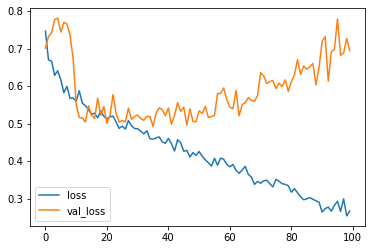

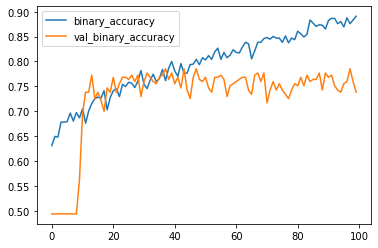

In [17]:
history100_frame = pd.DataFrame(history100.history)
history100_frame.loc[:, ['loss', 'val_loss']].plot()
history100_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [18]:
MyModel.load_weights('My_model')
history40 = MyModel.fit(
    ds_train,
    validation_data=ds_val,
    epochs=25,
)

Epoch 1/25
59/59 [==============================] - 2s 33ms/step - loss: 0.7210 - binary_accuracy: 0.6439 - val_loss: 0.7180 - val_binary_accuracy: 0.4936
Epoch 2/25
59/59 [==============================] - 2s 32ms/step - loss: 0.6304 - binary_accuracy: 0.6545 - val_loss: 0.7639 - val_binary_accuracy: 0.4936
Epoch 3/25
59/59 [==============================] - 2s 32ms/step - loss: 0.6143 - binary_accuracy: 0.6749 - val_loss: 0.7764 - val_binary_accuracy: 0.4936
Epoch 4/25
59/59 [==============================] - 2s 32ms/step - loss: 0.6004 - binary_accuracy: 0.6781 - val_loss: 0.7518 - val_binary_accuracy: 0.4936
Epoch 5/25
59/59 [==============================] - 2s 32ms/step - loss: 0.5908 - binary_accuracy: 0.6877 - val_loss: 0.7009 - val_binary_accuracy: 0.4936
Epoch 6/25
59/59 [==============================] - 2s 32ms/step - loss: 0.5612 - binary_accuracy: 0.7102 - val_loss: 0.7291 - val_binary_accuracy: 0.4936
Epoch 7/25
59/59 [==============================] - 2s 32ms/step - los

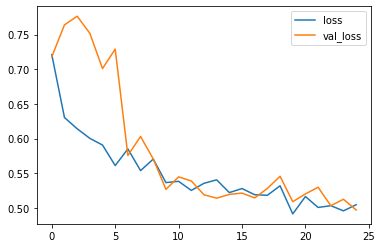

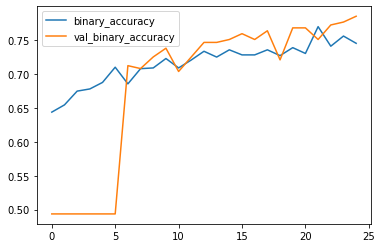

In [19]:
history40_frame = pd.DataFrame(history40.history)
history40_frame.loc[:, ['loss', 'val_loss']].plot()
history40_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

## 5. Results
 

In [20]:
predictions = MyModel.predict(ds_train)
b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  518 
 - Bénins:  417 
 - Total comp:  935  vs  935


In [21]:
predictions = MyModel.predict(ds_val)
b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  123 
 - Bénins:  110 
 - Total comp:  233  vs  233


In [22]:
def predict_class_label_number(dataset):
    predictions =  MyModel.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.show()

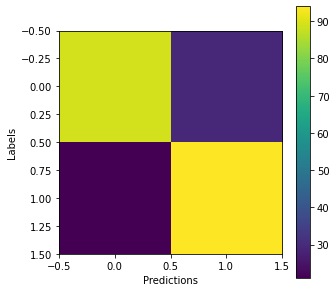

In [23]:
dataset = ds_val
confusion_mtx_My = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx_My, [0,1])

## 6. Comparison with other models using transfer learning

In this part, the results obtained are compared to the ones obtained with transfer learning using two commonly used models for classification that are Mobilenet from Google and VGG16 from Oxford but no fine tuning will be done here. These models are pretrained on the 'imagenet' dataset. 
This part is inspired by this tutorial from tensorflow : https://www.tensorflow.org/tutorials/images/transfer_learning

### 6.1 Mobilenet 

In [24]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [25]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


In [26]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [27]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomFlip(mode='horizontal'), 
    preprocessing.RandomFlip(mode='vertical'), 
    preprocessing.RandomRotation(factor=0.20),  
])

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [29]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [30]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelMobilenet = tf.keras.Model(inputs, outputs)

In [31]:
base_learning_rate = 0.0001
modelMobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', 'binary_accuracy'])

In [32]:
modelMobilenet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0     

In [33]:
initial_epochs = 25

In [34]:
historyMobilenet = modelMobilenet.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_val)

Epoch 1/25
59/59 [==============================] - 4s 32ms/step - loss: 0.7321 - accuracy: 0.5701 - binary_accuracy: 0.5701 - val_loss: 0.6634 - val_accuracy: 0.6223 - val_binary_accuracy: 0.6223
Epoch 2/25
59/59 [==============================] - 1s 16ms/step - loss: 0.7125 - accuracy: 0.5775 - binary_accuracy: 0.5775 - val_loss: 0.6422 - val_accuracy: 0.6567 - val_binary_accuracy: 0.6567
Epoch 3/25
59/59 [==============================] - 1s 16ms/step - loss: 0.6636 - accuracy: 0.6214 - binary_accuracy: 0.6214 - val_loss: 0.6269 - val_accuracy: 0.6781 - val_binary_accuracy: 0.6781
Epoch 4/25
59/59 [==============================] - 1s 16ms/step - loss: 0.6613 - accuracy: 0.6267 - binary_accuracy: 0.6267 - val_loss: 0.6143 - val_accuracy: 0.6781 - val_binary_accuracy: 0.6781
Epoch 5/25
59/59 [==============================] - 1s 16ms/step - loss: 0.6373 - accuracy: 0.6471 - binary_accuracy: 0.6471 - val_loss: 0.6068 - val_accuracy: 0.6910 - val_binary_accuracy: 0.6910
Epoch 6/25
59/5

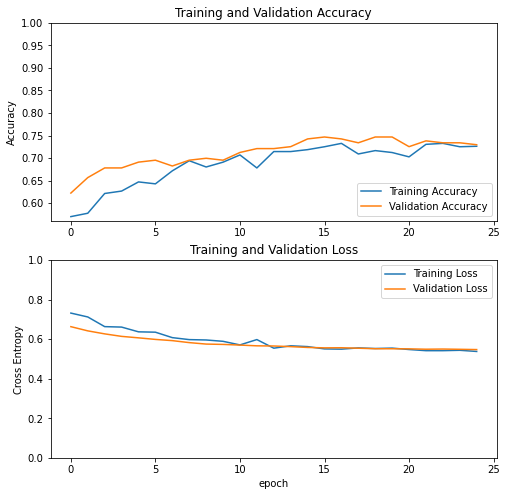

In [35]:
acc = historyMobilenet.history['accuracy']
val_acc = historyMobilenet.history['val_accuracy']

loss = historyMobilenet.history['loss']
val_loss = historyMobilenet.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
predictions = modelMobilenet.predict(ds_val)

b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  124 
 - Bénins:  109 
 - Total comp:  233  vs  233


In [37]:
def predict_class_label_number(dataset):
    predictions =  modelMobilenet.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.show()

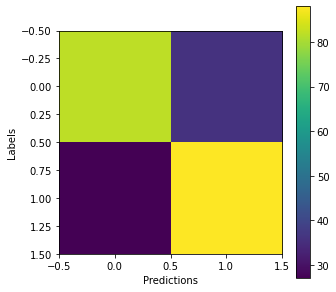

In [38]:
dataset = ds_val
confusion_mtx_Mobilenet = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx_Mobilenet, [0,1])

### 6.2 VGG16 

In [39]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling=None,
    classes=2,
    classifier_activation='softmax'
)

In [40]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 512)


In [41]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [43]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [44]:
inputs = tf.keras.Input(shape=(160,160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
modelVGG16 = tf.keras.Model(inputs, outputs)

In [45]:
base_learning_rate = 0.001
modelVGG16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', 'binary_accuracy'])

In [46]:
modelVGG16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.add (TFOpLambda)     (None, 160, 160, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0   

In [47]:
initial_epochs = 25

In [48]:
historyVGG16 = modelVGG16.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_val)

Epoch 1/25
59/59 [==============================] - 3s 38ms/step - loss: 1.5998 - accuracy: 0.5112 - binary_accuracy: 0.5112 - val_loss: 0.9735 - val_accuracy: 0.6180 - val_binary_accuracy: 0.6180
Epoch 2/25
59/59 [==============================] - 2s 33ms/step - loss: 1.2665 - accuracy: 0.5850 - binary_accuracy: 0.5850 - val_loss: 0.7178 - val_accuracy: 0.6738 - val_binary_accuracy: 0.6738
Epoch 3/25
59/59 [==============================] - 2s 33ms/step - loss: 0.8995 - accuracy: 0.6556 - binary_accuracy: 0.6556 - val_loss: 0.5975 - val_accuracy: 0.7210 - val_binary_accuracy: 0.7210
Epoch 4/25
59/59 [==============================] - 2s 34ms/step - loss: 0.8159 - accuracy: 0.6952 - binary_accuracy: 0.6952 - val_loss: 0.5802 - val_accuracy: 0.7039 - val_binary_accuracy: 0.7039
Epoch 5/25
59/59 [==============================] - 2s 34ms/step - loss: 0.7158 - accuracy: 0.6973 - binary_accuracy: 0.6973 - val_loss: 0.5457 - val_accuracy: 0.7253 - val_binary_accuracy: 0.7253
Epoch 6/25
59/5

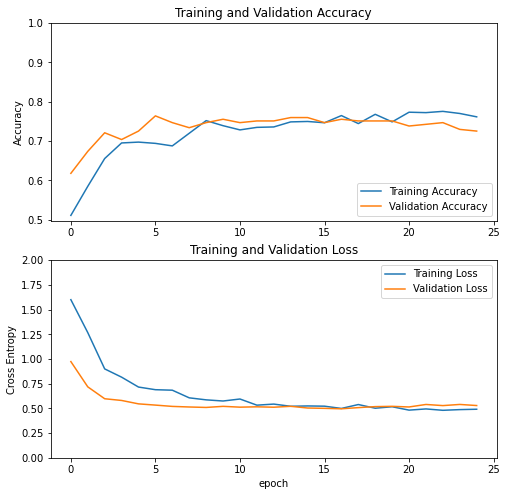

In [49]:
acc = historyVGG16.history['accuracy']
val_acc = historyVGG16.history['val_accuracy']

loss = historyVGG16.history['loss']
val_loss = historyVGG16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
predictions = modelVGG16.predict(ds_val)
b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  103 
 - Bénins:  130 
 - Total comp:  233  vs  233


In [51]:
def predict_class_label_number(dataset):
    predictions =  modelVGG16.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Predictions')
    plt.ylabel('Labels')
    plt.show()

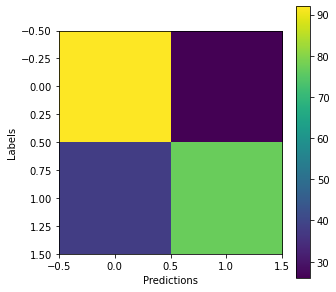

In [52]:
dataset = ds_val
confusion_mtx_VGG16 = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx_VGG16, [0,1])

### 6.3 Comparison of the confusion matrices

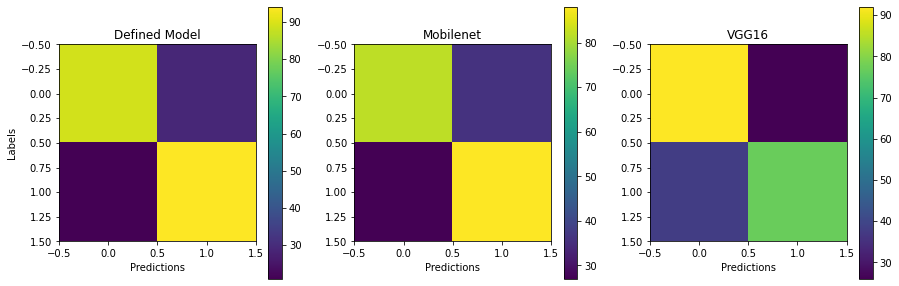

In [59]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(confusion_mtx_My)
plt.title('Defined Model')
plt.xlabel('Predictions')
plt.ylabel('Labels')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(confusion_mtx_Mobilenet)
plt.xlabel('Predictions')
plt.title('Mobilenet')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(confusion_mtx_VGG16)
plt.xlabel('Predictions')
plt.title('VGG16')
plt.colorbar()
plt.show()